In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from datetime import datetime
import itertools
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import xarray as xr
import regionmask
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from collections import OrderedDict
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

## DATA

### Climate: UEA CRU TS4.07 (1901-2022)

In [262]:
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.pre.dat.nc"
file2 = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.tmx.dat.nc"

file_paths_list =[file,file2]
monthly_forecast=xr.Dataset()

for file in file_paths_list:
        monthly_forecast = xr.merge([monthly_forecast,xr.open_mfdataset(file)], compat='override')

### Conflict events: ACLED

In [263]:
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/ACLED_1997-01-01-2023-07-18_Somalia.csv"
df = pd.read_csv(file)

### Administrative boundaries of Somalia

In [264]:
path = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm2_ocha_20230308.shp"
states_gdf = gpd.read_file(path) 

/tmp/ipykernel_5774/3894211376.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(states_gdf.geometry.centroid.x, states_gdf.geometry.centroid.y, states_gdf['ADM2_EN']):


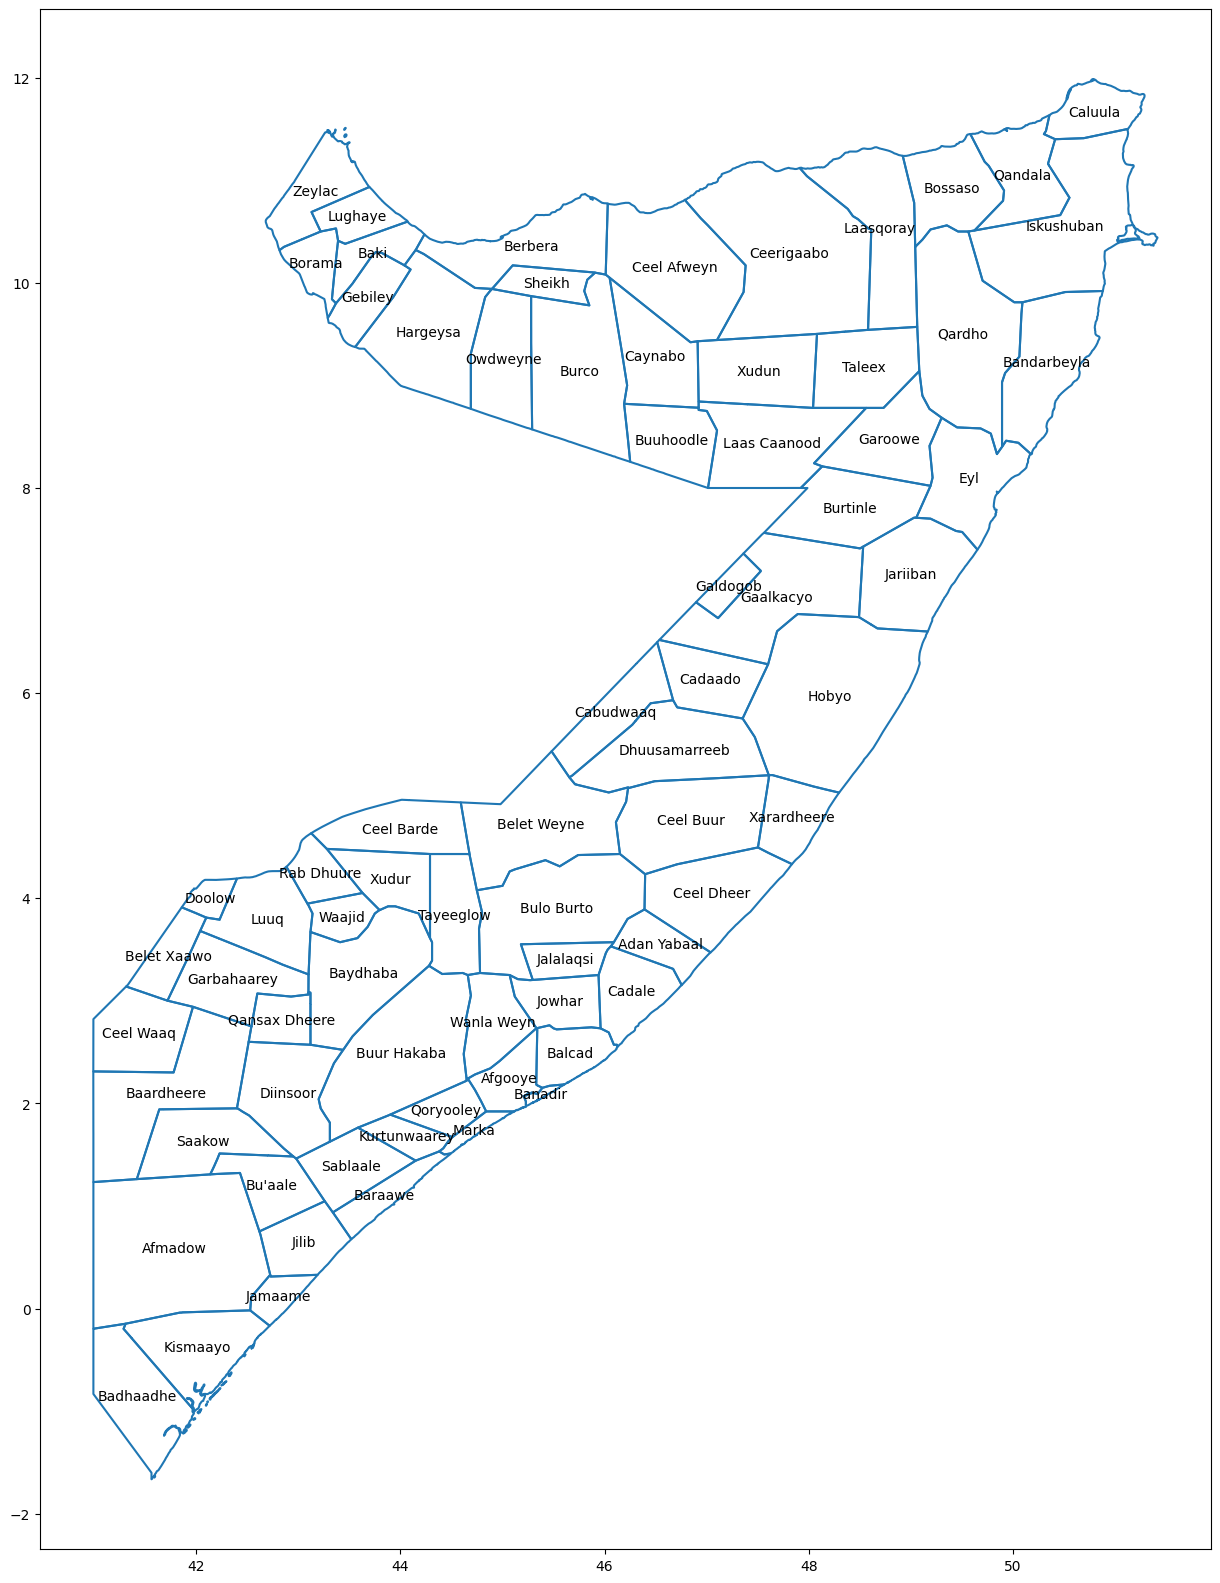

In [265]:
# plot a figure of states_gdf
fig, ax = plt.subplots(1, 1)
#chnge figsize
fig.set_size_inches(20, 20)
#add names of subregions
for x, y, label in zip(states_gdf.geometry.centroid.x, states_gdf.geometry.centroid.y, states_gdf['ADM2_EN']):
    ax.text(x, y, label, fontsize = 10, ha = 'center', va = 'center')
states_gdf.boundary.plot(ax=ax)
plt.show()

In [266]:
['Baidoa', 'Balcad', 'Banadir', 'Baraawe', 'Galdogob', 'Kismayo',
       'Qoryooley', 'Baki', 'Doolow', 'Sheikh', 'Badhan', 'Dhahar',
       'Lasqoray']

['Baidoa',
 'Balcad',
 'Banadir',
 'Baraawe',
 'Galdogob',
 'Kismayo',
 'Qoryooley',
 'Baki',
 'Doolow',
 'Sheikh',
 'Badhan',
 'Dhahar',
 'Lasqoray']

### Displacements : UNHCR

In [267]:
df_disp = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")

### Population density Data

In [268]:
asc = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/gpw_v4_admin_unit_center_points_population_estimates_rev11_som.csv"
population_density = pd.read_csv(asc)

# Data manipulation

## Climate data manipulation

In [269]:
#Limit the lat-lon and time

def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(states_gdf)

In [270]:
start_date = '1901-01-01'
end_date = '2022-12-31'

region = monthly_forecast[["pre",'tmx']].sel(
    time=slice(start_date, end_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

In [271]:
# Interpolate data onto a finer grid
region_mask = regionmask.mask_3D_geopandas(states_gdf,
                                         monthly_forecast.lon,
                                         monthly_forecast.lat)

temp_pre = region.where(region_mask)
temp_pre = temp_pre.groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()

In [ ]:
#add to temp_pre a column with the name of the region in states_gdf['ADM2_EN'] that matches the column region in temp_pre
temp_pre=temp_pre.merge(states_gdf['ADM2_EN'], left_on='region', right_index=True).sort_index()

#rename the column with the name of the region
temp_pre.rename(columns = {'ADM2_EN':'admin2'}, inplace = True)

In [ ]:
# Calculate the mean tmx and pre for the neighboring districts
mean_t = temp_pre[(temp_pre['admin2']=='Afgooye')].groupby('time')['tmx'].sum()
mean_p = temp_pre[(temp_pre['admin2']=='Afgooye')].groupby('time')['pre'].sum()
new_data = pd.DataFrame({ 'admin2': 'Banadir', 'tmx': mean_t, 'pre': mean_p}).reset_index()

# Append the new DataFrame to the original DataFrame
temp_pre_m = pd.concat([temp_pre, new_data])
temp_pre = temp_pre_m.sort_values(by=['time', 'admin2'], ascending=[True, True]).reset_index(drop=True)

In [ ]:
# Only keep month and year in time column 
temp_pre['time'] = pd.to_datetime(temp_pre['time']).dt.strftime('%Y-%m-%d')
temp_pre['month'] = temp_pre['time'].str[5:7]
temp_pre['month_year'] = temp_pre['time'].str[:7]
temp_pre = temp_pre[['month_year','admin2','tmx','pre']]
temp_pre = temp_pre.rename(columns={'month_year':'time'})

## Conflict data manipulation

In [ ]:
# Modify event_date column to datetime

df['event_date'] = pd.to_datetime(df['event_date'])
df = df.set_index('event_date') 

conflict = df.groupby([pd.Grouper(freq='M'),"admin2"]).count()
conflict.reset_index(level=[0, 1], inplace=True)
conflict = conflict[['event_date','admin2','year']].rename(columns={'year': 'conflicts','event_date': 'time'})

# Aggregate the datetime objects by month
conf = conflict.groupby([pd.Grouper(key='time', freq='M'),'admin2'])['conflicts'].sum().to_frame()

In [ ]:
# Reindex the DataFrame with all dates and districts and fill missing values with 0

dates = conf.index.get_level_values('time').unique()
districts = conf.index.get_level_values('admin2').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts], names=['time', 'admin2'])

conflicts = conf.reindex(all_combinations, fill_value=0).reset_index()    
conflicts = conflicts.sort_values(by=['time', 'admin2'], ascending=[True, True])
conflicts.reset_index(drop=True, inplace=True)
conflicts['time'] = conflicts['time'].dt.strftime('%Y-%m').values

# Merge the two DataFrames temp_pre and conflicts
df_2016 = pd.merge(temp_pre, conflicts, on=['time','admin2'], how='outer')

## Displacements data manipulation

In [ ]:
df_disp = df_disp[(df_disp['Reason']=='Drought related')]

In [ ]:
v= df_disp["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]

for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i]))
    
df_disp.insert(loc=3, column='date_timestamp', value=q)
df_disp = df_disp.sort_values("date_timestamp")

df_disp['Month End'] = pd.to_datetime(df_disp['Month End'], dayfirst=True)

In [ ]:
aggregated_data = df_disp.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) District', 'Current (Arrival) District'])['Number of Individuals'].sum().to_frame()

# Get the unique values of 'Month End' and 'Previous (Departure) Region' 
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) District').unique()

all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) District','Current (Arrival) District'])

# Reindex the aggregated_data DataFrame with 'all_combinations'
disp_data = aggregated_data.reindex(all_combinations, fill_value=0).reset_index()   

In [ ]:
common_elements = temp_pre.loc[temp_pre['admin2'].isin(disp_data['Previous (Departure) District']), 'admin2']

# Print common elements
print(len(common_elements.unique()))

#print elements that are in disp_data but not in temp_pre
disp_data.loc[~disp_data['Previous (Departure) District'].isin(temp_pre['admin2']), 'Previous (Departure) District'].unique()

65


array(['Baidoa', 'Balcad', 'Baraawe', 'Galdogob', 'Kismayo', 'Qoryooley',
       'Baki', 'Doolow', 'Sheikh', 'Badhan', 'Dhahar', 'Lasqoray'],
      dtype=object)

In [ ]:
temp_pre.loc[~temp_pre['admin2'].isin(disp_data['Previous (Departure) District']), 'admin2'].unique()

array(['Baydhaba', 'Kismaayo'], dtype=object)

In [ ]:
disp_matxs = disp_data.pivot_table(index=['time','Current (Arrival) District'], columns='Previous (Departure) District', values='Number of Individuals', aggfunc='sum').reset_index()
disp_matxs = disp_matxs.rename(columns={'Current (Arrival) District': 'admin2'})
temp_pre['admin2'].replace({'Baydhaba':'Baidoa','Kismaayo':'Kismayo'}, inplace=True)

#remove the day from the date
disp_matxs['time'] = disp_matxs['time'].map(lambda x: x.strftime('%Y-%m'))
#disp_matxs = disp_matxs.drop(columns=['time'])
#temp_pre_c['yr_mth'] = pd.to_datetime(temp_pre_c['time'], format='%Y-%m', dayfirst=True).map(lambda x: x.strftime('%Y-%m'))

#df_2016 = df_2016.rename(columns={'time': 'yr_mth'})
df_merged_d = pd.merge(df_2016, disp_matxs, on=['time', 'admin2'], how='outer')

In [ ]:
#add a column with the sum of the displacements
df_merged_d['sum_disp'] = df_merged_d.iloc[:, -77:].sum(axis=1)

## Compute TA, PA, DL

In [ ]:
# Split the dataframe into regions

reg=[]
for admin in df_merged_d['admin2'].unique():
    a = df_merged_d[df_merged_d['admin2']==admin].reset_index(drop=True)
    reg.append(a)

In [ ]:
# Calculate the TA (temperature anomaly), PA (precipitation anomaly) and DL (drought lenght) for each region

avg_t = avg_p = std_t = std_p = np.zeros(len(df_merged_d['admin2'].unique()))

for i in range(len(df_merged_d['admin2'].unique())):

    reg[i]['year'] , reg[i]['month'] = reg[i]['time'].str[:4] , reg[i]['time'].str[5:7]

    # TA
    mean_temp_i , std_temp_i  = reg[i].groupby('month')['tmx'].mean() , reg[i].groupby('month')['tmx'].std()
    reg[i]['avg_temp'] , reg[i]['std_temp']  = reg[i]['month'].map(mean_temp_i) , reg[i]['month'].map(std_temp_i)
    reg[i]['diff_t']= (reg[i]['tmx']-reg[i]['avg_temp'])/reg[i]['std_temp']
    reg[i]['TA'] = (reg[i]['diff_t'].shift(3) + reg[i]['diff_t'].shift(2) + reg[i]['diff_t'].shift(1) + reg[i]['diff_t'])/4

    # PA
    mean_pre_i , std_pre_i  = reg[i].groupby('month')['pre'].mean() , reg[i].groupby('month')['pre'].std()
    reg[i]['avg_pre'] , reg[i]['std_pre']= reg[i]['month'].map(mean_pre_i) , reg[i]['month'].map(std_pre_i)
    reg[i]['diff_p']= (reg[i]['pre']-reg[i]['avg_pre'])/reg[i]['std_pre']
    reg[i]['PA'] = (reg[i]['diff_p'].shift(3) + reg[i]['diff_p'].shift(2) + reg[i]['diff_p'].shift(1) + reg[i]['diff_p'])/4
    
    # DL 
    reg[i]['DL'] = 0
    mask = reg[i]['TA'] > 0
    group_id = (mask != mask.shift()).cumsum()             # Create a group identifier for each consecutive group
    count = reg[i].groupby(group_id).cumcount() + 1        # Calculate the count within each group
    reg[i]['DL'] = np.where(mask, count, 0)                # Assign the count values to the 'DL' column

    # Add lagged variables
    reg[i]['TA_lag1'], reg[i]['TA_lag2'], reg[i]['TA_lag3'], reg[i]['TA_lag4'], reg[i]['TA_lag5'], reg[i]['TA_lag6'] = reg[i]['TA'].shift(1), reg[i]['TA'].shift(2), reg[i]['TA'].shift(3), reg[i]['TA'].shift(4), reg[i]['TA'].shift(5), reg[i]['TA'].shift(6)
    reg[i]['PA_lag1'], reg[i]['PA_lag2'], reg[i]['PA_lag3'], reg[i]['PA_lag4'], reg[i]['PA_lag5'], reg[i]['PA_lag6'] = reg[i]['PA'].shift(1), reg[i]['PA'].shift(2), reg[i]['PA'].shift(3), reg[i]['PA'].shift(4), reg[i]['PA'].shift(5), reg[i]['PA'].shift(6)
    reg[i]['DL_lag1'], reg[i]['DL_lag2'], reg[i]['DL_lag3'], reg[i]['DL_lag4'], reg[i]['DL_lag5'], reg[i]['DL_lag6'] = reg[i]['DL'].shift(1), reg[i]['DL'].shift(2), reg[i]['DL'].shift(3), reg[i]['DL'].shift(4), reg[i]['DL'].shift(5), reg[i]['DL'].shift(6)
    reg[i]['conflicts_lag1'], reg[i]['conflicts_lag2'], reg[i]['conflicts_lag3'], reg[i]['conflicts_lag4'], reg[i]['conflicts_lag5'], reg[i]['conflicts_lag6'] = reg[i]['conflicts'].shift(1), reg[i]['conflicts'].shift(2), reg[i]['conflicts'].shift(3), reg[i]['conflicts'].shift(4), reg[i]['conflicts'].shift(5), reg[i]['conflicts'].shift(6)
    reg[i]['sum_disp_lag1'], reg[i]['sum_disp_lag2'], reg[i]['sum_disp_lag3'], reg[i]['sum_disp_lag4'], reg[i]['sum_disp_lag5'], reg[i]['sum_disp_lag6'] = reg[i]['sum_disp'].shift(1), reg[i]['sum_disp'].shift(2), reg[i]['sum_disp'].shift(3), reg[i]['sum_disp'].shift(4), reg[i]['sum_disp'].shift(5), reg[i]['sum_disp'].shift(6)
    reg[i] = reg[i].reset_index()

In [ ]:
temp_pre_c = pd.concat([reg[i] for i in range(len(df_merged_d['admin2'].unique()))], axis=0)
#temp_pre_c = temp_pre_c.dropna()
# drop all entries before 2016-01 and after 2022-12
temp_pre_c = temp_pre_c[(temp_pre_c['time'] >= '2016-01') & (temp_pre_c['time'] <= '2022-12')]
# Select a subset of the dataframes from 1997-01 to 2022-12
temp_pre_c = temp_pre_c.fillna(0)
temp_pre_c = temp_pre_c.drop(['avg_temp', 'avg_pre', 'std_temp', 'std_pre', 'diff_t', 'diff_p'], axis=1)
temp_pre_c = temp_pre_c.sort_values(by=['time','admin2'], ascending=[True, True]).reset_index(drop=True)

In [ ]:
# disp_data['Number of Individuals'].sum() only up to 2022
disp_data = disp_data[(disp_data['time'] >= '2016-01') & (disp_data['time'] <= '2022-12')]

In [ ]:
#count disp_data
disp_data['Number of Individuals'].sum(),temp_pre_c['sum_disp'].sum()

(7030751, 7115434.0)

In [ ]:
#temp_pre_c.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_districts.csv", index = False, header=True)

In [ ]:
temp_pre_c[temp_pre_c['admin2']=='Banadir']['sum_disp'].sum()

1449898.0

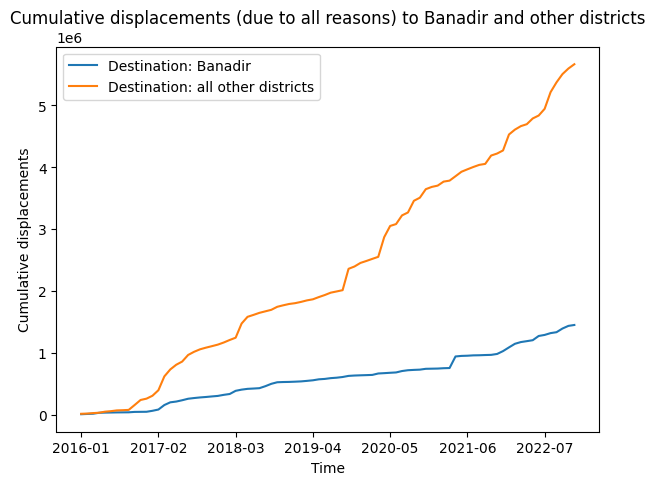

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

df_no_ban = temp_pre_c[temp_pre_c['admin2']!='Banadir']
df_ban = temp_pre_c[temp_pre_c['admin2']=='Banadir']

#plt.plot(df_no_ban.groupby('time')['sum_disp'].sum(), label='No Banadir')
#plt.plot(df_ban.groupby('time')['sum_disp'].sum(), label='Banadir')

plt.plot(df_ban.groupby('time')['sum_disp'].sum().cumsum(), label='Destination: Banadir')
plt.plot(df_no_ban.groupby('time')['sum_disp'].sum().cumsum(), label='Destination: all other districts')
plt.xticks(np.arange(0, len(df_no_ban['time'].unique()), 13))
plt.xlabel('Time')
plt.ylabel('Cumulative displacements')
plt.title('Cumulative displacements (due to drought) to Banadir and other districts')
#invert order of labels in legend
plt.legend()
plt.show()

In [1]:
from haversine import haversine, Unit

states_gdf['ADM2_EN'].replace({'Baydhaba':'Baidoa','Kismaayo':'Kismayo'}, inplace=True)
states_gdf['centroid'] = states_gdf.geometry.centroid

# Initialize an empty DataFrame
dist_matrix = pd.DataFrame(index=states_gdf['ADM2_EN'], columns=states_gdf['ADM2_EN'])

# Calculate the haversine distance between each pair of districts
for i, dis1 in enumerate(states_gdf['ADM2_EN']):
    for j, dis2 in enumerate(states_gdf['ADM2_EN']):
        dist_matrix.loc[dis1, dis2] = haversine(states_gdf.loc[i, 'centroid'].coords[0], states_gdf.loc[j, 'centroid'].coords[0])

NameError: name 'states_gdf' is not defined

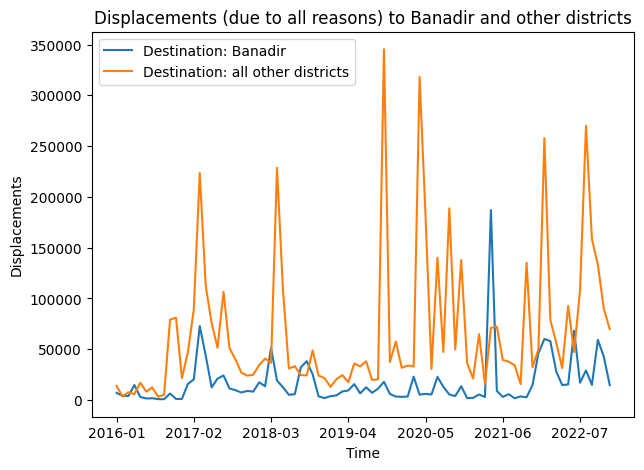

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

df_no_ban = temp_pre_c[temp_pre_c['admin2']!='Banadir']
df_ban = temp_pre_c[temp_pre_c['admin2']=='Banadir']

#plt.plot(df_no_ban.groupby('time')['sum_disp'].sum(), label='No Banadir')
#plt.plot(df_ban.groupby('time')['sum_disp'].sum(), label='Banadir')

plt.plot(df_ban.groupby('time')['sum_disp'].sum(), label='Destination: Banadir')
plt.plot(df_no_ban.groupby('time')['sum_disp'].sum(), label='Destination: all other districts')
plt.xticks(np.arange(0, len(df_no_ban['time'].unique()), 13))
plt.xlabel('Time')
plt.ylabel('Displacements')
plt.title('Displacements (due to drought) to Banadir and other districts')
#invert order of labels in legend
plt.legend()
plt.show()

In [ ]:
df_ban.groupby('time')['sum_disp'].sum().cumsum()

time
2016-01       7018.0
2016-02      11230.0
2016-03      15171.0
2016-04      29973.0
2016-05      32973.0
             ...    
2022-08    1318200.0
2022-09    1333128.0
2022-10    1392405.0
2022-11    1435168.0
2022-12    1449898.0
Name: sum_disp, Length: 84, dtype: float64

In [ ]:
df_no_ban.groupby('time')['sum_disp'].sum().cumsum()

time
2016-01      13995.0
2016-02      17513.0
2016-03      25175.0
2016-04      30941.0
2016-05      48022.0
             ...    
2022-08    5213953.0
2022-09    5372511.0
2022-10    5505689.0
2022-11    5595583.0
2022-12    5665536.0
Name: sum_disp, Length: 84, dtype: float64